In [1]:
import sympy
from sympy import Symbol, sqrt, cos, pi, symbols
import numpy as np
import matplotlib.pylab as plt

import qnet
from qnet.algebra import *
from qnet.printing import srepr

import QDYN

from src.notebook_plots_v1 import plot_bs_decay, display_hamiltonian, display_eq, show_summary_dicke
from src.single_sided_network_v1 import network_slh
from src.single_sided_node_v1 import node_slh
from src.qdyn_model_v1 import make_qdyn_oct_model

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
qnet.init_printing()

$
\newcommand{ket}[1]{\vert #1 \rangle}
\newcommand{bra}[1]{\langle #1 \vert}
\newcommand{Op}[1]{\hat{#1}}
$

# Using STIRAP for the dicke-initialization

## System description

### Description of a network node

Each node of our network consists of a driven $\Lambda$-type atom embedded in a cavity [@CiracPRL1997]. After adiabatic elimination of the $\ket{r}$-state, the Hamiltonian and Lindblad operator of the node read

In [4]:
slh_node = node_slh(1, n_cavity=3)
display_hamiltonian(slh_node.H)

<IPython.core.display.Latex object>

and

In [5]:
display_eq('\Op{L} ', slh_node.L)

<IPython.core.display.Latex object>

respectively.

Adding a coherent displacement feeding into the node additionally drives the cavity:

In [6]:
Ω_α, Ω_1, α = symbols('Omega_alpha Omega_1 alpha', positive=True)
κ = Symbol('kappa', positive=True); λ = Symbol('lambda', positive=True); μ = Symbol('mu', positive=True)
H_node_driven = (slh_node << qnet.cc.Displace('W', alpha=α)).toSLH().H.substitute(
    {α: λ/sqrt(2*κ) * Ω_α.conjugate()})
H_node_driven

-I*Ω_1*g_1/(2*Δ_1) * (σ̂_e,g^(q₁) ⊗ â^(c₁) - σ̂_g,e^(q₁) ⊗ â^(c₁)†) + g_1**2/Δ_1 * Π̂_g^(q₁) ⊗ â^(c₁)† â^(c₁) + I/2 * (-Ωₐₗₚₕₐ⋅λ * â^(c₁)† + Ωₐₗₚₕₐ⋅λ * â^(c₁)) - g_1**2/Δ_1 * â^(c₁)† â^(c₁)

In [7]:
[srepr(s) for s in H_node_driven.all_symbols()]

["Symbol('Omega_alpha', positive=True)",
 "Symbol('g_1', positive=True)",
 "Symbol('Delta_1', real=True)",
 "Symbol('lambda', positive=True)",
 "Symbol('Omega_1')"]

In [8]:
g_1, Δ_1 = Symbol('g_1', positive=True), Symbol('Delta_1', real=True)

Here, we have renormalized the displacement amplitude as $\alpha \rightarrow \frac{\lambda \Omega_\alpha^*}{\sqrt{2 \kappa}}$. The factor $\sqrt{2\kappa}$ ensures that $\Omega_a$ is in units of energy, and the dimensionless $\lambda = g_1 / \Delta_1$ rescales $\Omega_\alpha$ have comparable amplitudes as $\Omega_1$.

It is instructive to write out this Hamiltonian in a matrix representation,

In [9]:
H_matrix = qnet.convert.convert_to_sympy_matrix(H_node_driven).subs({g_1/Δ_1: λ, Symbol('Omega_1'): Ω_1}).subs({λ: μ})#.subs({g_1: 0})

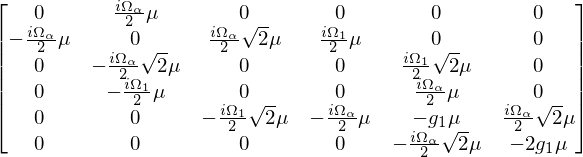

In [10]:
H_matrix

In [11]:
mat_rows = []
for row in range(H_matrix.rows):
    vals = [sympy.mathematica_code(v) for v in H_matrix.row(row)]
    mat_rows.append("{" + ", ".join(vals) + "}")
mat_code = "mat = {" + ",\n".join(mat_rows) + "\n}"
print(mat_code.replace('lambda', 'λ').replace('Omega', 'Ω').replace('alpha', 'α').replace('_',''))

mat = {{0, (1/2)*I*Ωα*mu, 0, 0, 0, 0},
{-1/2*I*Ωα*mu, 0, (1/2)*2^(1/2)*I*Ωα*mu, (1/2)*I*Ω1*mu, 0, 0},
{0, -1/2*2^(1/2)*I*Ωα*mu, 0, 0, (1/2)*2^(1/2)*I*Ω1*mu, 0},
{0, -1/2*I*Ω1*mu, 0, 0, (1/2)*I*Ωα*mu, 0},
{0, 0, -1/2*2^(1/2)*I*Ω1*mu, -1/2*I*Ωα*mu, -g1*mu, (1/2)*2^(1/2)*I*Ωα*mu},
{0, 0, 0, 0, -1/2*2^(1/2)*I*Ωα*mu, -2*g1*mu}
}


where the rows/colums correspond to the following quantum numbers:

In [12]:
slh_node.H.space.basis_labels

('g,0', 'g,1', 'g,2', 'e,0', 'e,1', 'e,2')

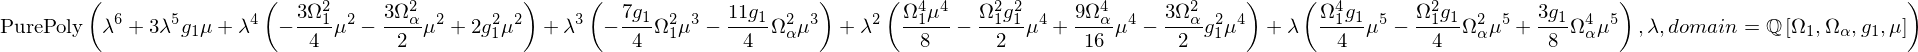

In [13]:
H_matrix.charpoly()

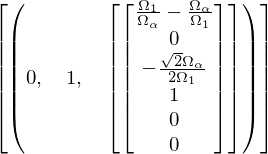

In [14]:
H_matrix.eigenvects()

In [15]:
ev0 = H_matrix.eigenvects()[0][2][0]

In [16]:
ev0_norm = ev0.normalized()

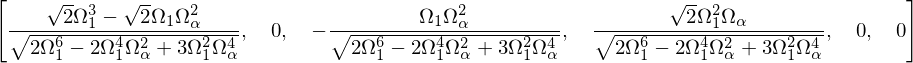

In [17]:
components = [a.cancel() for a in ev0_norm]
components

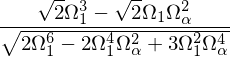

In [18]:
components[0]

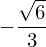

In [19]:
sympy.limit(components[0], Ω_1, 0)

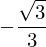

In [20]:
sympy.limit(components[2], Ω_1, 0)

In [21]:
sympy.limit(components[3], Ω_1, 0)

In [22]:
sympy.limit(components[0], Ω_α, 0)

In [23]:
sympy.limit(components[2], Ω_α, 0)

In [24]:
sympy.limit(components[3], Ω_α, 0)

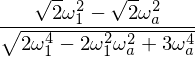

In [25]:
limit0 = sympy.limit(sympy.limit(components[0], Ω_α, Symbol('omega_a')), Ω_1, Symbol('omega_1'))
limit0

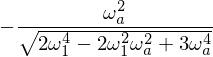

In [26]:
limit2 = sympy.limit(sympy.limit(components[2], Ω_α, Symbol('omega_a')), Ω_1, Symbol('omega_1'))
limit2

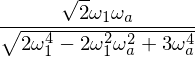

In [27]:
limit3 = sympy.limit(sympy.limit(components[3], Ω_α, Symbol('omega_a')), Ω_1, Symbol('omega_1'))
limit3

In [28]:
sols = sympy.solve(limit3-1,  Symbol('omega_1'))

In [29]:
abs(sympy.N(limit0.subs({Symbol('omega_1'): sols[0]}).simplify().subs({Symbol('omega_a'): 1})))

In [30]:
abs(sympy.N(limit2.subs({Symbol('omega_1'): sols[0]}).simplify().subs({Symbol('omega_a'): 1})))

In [31]:
abs(sympy.N(limit3.subs({Symbol('omega_1'): sols[0]}).simplify().subs({Symbol('omega_a'): 1})))

In [32]:
x = sols[0]

### Standard STIRAP

In [33]:
H_stirap = - sympy.Matrix(
    [[0, Ω_α, 0],
    [Ω_α, 0, Ω_1],
    [0, Ω_1, 0]]
) / 2

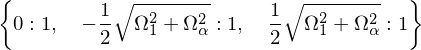

In [34]:
H_stirap.eigenvals()

In [35]:
ev_stirap = H_stirap.eigenvects()

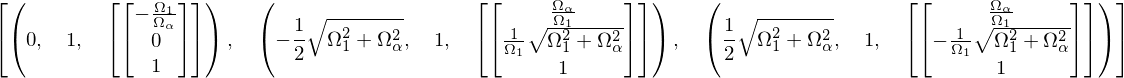

In [36]:
ev_stirap

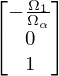

In [37]:
ev_stirap0 = ev_stirap[0][2][0]
ev_stirap0

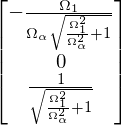

In [38]:
ev_stirap0.normalized()